М8О-109СВ
Дрёмов Алексаднр

{ФКИИ} Лабораторная работа №4 (Восстановление функции распренделения вероятности)

  1. Реализовать метод восстановления плотности вероятности двумя способами:
    * EM-алгоритм;
    * Ядерное сглаживание;
  2. Применить данные методы на любом наборе случайных точек.

ФП смеси двух нормальных распределений есть

\begin{equation*}
  f(x) = w_{1} \cdot N(x | \mu_{1}, \sigma_{1}^{2}) + w_{2} \cdot N(x | \mu_{2}, \sigma_{2}^{2}),
\end{equation*}

где $w_{1} + w_{2} = 1$ и $N(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2 \pi \sigma^{2}}} e^{\left( -\frac{(x - \mu)^{2}}{2\sigma^{2}} \right)} $.

In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
np.random.seed(0)
data = np.concatenate([np.random.normal(loc=-2, scale=1, size=500),
                       np.random.normal(loc=2, scale=0.5, size=300)])
data = np.sort(data)

In [62]:
def normal_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

EM-алгоритм состоит из двух шагов:
 * Вычисление вероятности принадлежности каждой точки к каждому компоненту смеси;
 * Обновление параметров модели ($w_{i}$, $\mu_{i}$, $\sigma_{i}$).

In [63]:
def em_pdf_recovery(data, n_iter=100):
    N = len(data)

    w1, w2 = 0.5, 0.5
    mu1, mu2 = np.mean(data) - 1, np.mean(data) + 1
    sigma1, sigma2 = np.std(data), np.std(data)

    for _ in range(n_iter):

        # E-шаг
        gamma1 = w1 * normal_pdf(data, mu1, sigma1)
        gamma2 = w2 * normal_pdf(data, mu2, sigma2)
        total_gamma = gamma1 + gamma2

        gamma1 /= total_gamma
        gamma2 /= total_gamma

        # M-шаг
        w1 = np.mean(gamma1)
        w2 = np.mean(gamma2)

        mu1 = np.sum(gamma1 * data) / np.sum(gamma1)
        mu2 = np.sum(gamma2 * data) / np.sum(gamma2)

        sigma1 = np.sqrt(np.sum(gamma1 * (data - mu1) ** 2) / np.sum(gamma1))
        sigma2 = np.sqrt(np.sum(gamma2 * (data - mu2) ** 2) / np.sum(gamma2))

    # Оценка плотности на новых точках x
    x = np.linspace(data.min() - 1, data.max() + 1, 500)
    pdf_em = w1 * normal_pdf(x, mu1, sigma1) + w2 * normal_pdf(x, mu2, sigma2)

    return x, pdf_em

Основная формула для KDE:

\begin{equation*}
  \hat{f}(x) = \frac{1}{nh} \sum_{i=1}^{n} K \left( \frac{ x - x_{i} }{h} \right),
\end{equation*}

где $u = \frac{ x - x_{i} }{h} $ и $K(u) = \frac{1}{ \sqrt{2 \pi}} e^{ -\frac{u^2}{2} }$ есть гауссово ядро.

In [64]:
def kernel_smoothing(data, h=0.5):
    x = np.linspace(data.min() - 1, data.max() + 1, 500)
    pdf = np.zeros_like(x)

    for i in range(len(x)):
        for j in range(len(data)):
            diff = x[i] - data[j]
            pdf[i] += (1 / (h * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (diff / h) ** 2)

            # pdf[i] += norm.pdf(x[i], loc=data[j], scale=h)

    return x, pdf / len(data)

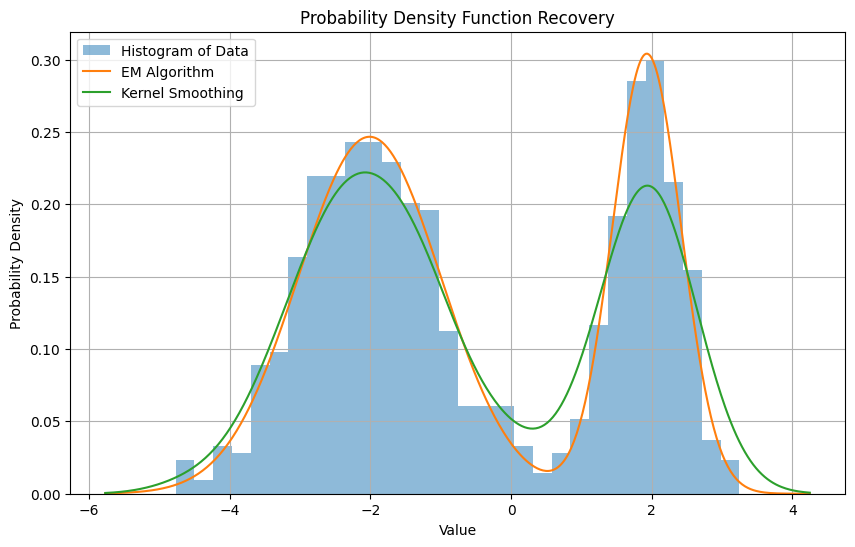

In [65]:
x_em, pdf_em = em_pdf_recovery(data, n_iter=100)
x_kernel, pdf_kernel = kernel_smoothing(data, h=0.5)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram of Data')

plt.plot(x_em, pdf_em, label='EM Algorithm')
plt.plot(x_kernel, pdf_kernel, label='Kernel Smoothing')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Function Recovery')
plt.legend()
plt.grid(True)
plt.show()

 {ФКИИ} Лабораторная работа №5 (Реализация методов Метрополиса-Гастингса и Гибсона для несимметричного распределения)  
   
Реализация методов Метрополиса-Гастингса и Гибсона для несимметричного распределения.
  1. Применить два метода на основе той функции плотности, которая была восстановлена в прошлом пункте, тем самым получив изначальные точки.
  2. В методе М-Г нарисовать картинку блуждания в случае 3D-функции плотности (на доп. баллы)
  3. Сравнить красный и синий набор точек (сгенерированые и исходные) (с помощью Расстояния Кульбака-Лейблера)

In [66]:
np.random.seed(0)
data = np.concatenate([np.random.normal(loc=-2, scale=1, size=500),
                       np.random.normal(loc=2, scale=0.5, size=300)])
data = np.sort(data)

In [67]:
def normal_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [68]:
def em_pdf_recovery(data, n_iter=100):
    N = len(data)

    w1, w2 = 0.5, 0.5
    mu1, mu2 = np.mean(data) - 1, np.mean(data) + 1
    sigma1, sigma2 = np.std(data), np.std(data)

    for _ in range(n_iter):

        # E-шаг
        gamma1 = w1 * normal_pdf(data, mu1, sigma1)
        gamma2 = w2 * normal_pdf(data, mu2, sigma2)
        total_gamma = gamma1 + gamma2

        gamma1 /= total_gamma
        gamma2 /= total_gamma

        # M-шаг
        w1 = np.mean(gamma1)
        w2 = np.mean(gamma2)

        mu1 = np.sum(gamma1 * data) / np.sum(gamma1)
        mu2 = np.sum(gamma2 * data) / np.sum(gamma2)

        sigma1 = np.sqrt(np.sum(gamma1 * (data - mu1) ** 2) / np.sum(gamma1))
        sigma2 = np.sqrt(np.sum(gamma2 * (data - mu2) ** 2) / np.sum(gamma2))

    # Оценка плотности на новых точках x
    x = np.linspace(data.min() - 1, data.max() + 1, 500)
    pdf_em = w1 * normal_pdf(x, mu1, sigma1) + w2 * normal_pdf(x, mu2, sigma2)

    gmm = {
        'weights': np.array([w1, w2]),
        'means': np.array([mu1, mu2]),
        'covariances': np.array([sigma1 ** 2, sigma2 ** 2])
    }

    return x, pdf_em, gmm

In [69]:
def pdf_function(x, gmm):
    w1, w2 = gmm['weights']
    mu1, mu2 = gmm['means']
    sigma1, sigma2 = np.sqrt(gmm['covariances'])

    pdf = w1 * normal_pdf(x, mu1, sigma1) + w2 * normal_pdf(x, mu2, sigma2)

    return pdf

In [70]:
x_em, pdf_em, gmm = em_pdf_recovery(data)

Алгоритм Метрополиса-Гастингса состоит из следующих шагов:

  1. Выбирается начальная точка $x_{0}$.
  2. Далее для каждой итерации:
    * выбирается $x^{'}$ по распределению $ q(x^{'} ; x^{(t)}) $;
    * Рассчитывается коэффициент $a(x^{'} ; x^{(t)}) = \min{ \left( 1 ; \frac{p^{\*} (x^{'})}{p^{\*} (x^{(t)})}\frac{ q( x^{(t)} ; x^{'} ) }{ q(x^{'} ; x^{(t)}) } \right) }$.

In [71]:
def metropolis_hastings(pdf, gmm, initial_point, n_samples=1000, proposal_std=0.5):
    samples = [initial_point]

    current_point = initial_point

    for _ in range(n_samples):
        proposed_point = np.random.normal(loc=current_point, scale=proposal_std)

        current_pdf = pdf(current_point, gmm)
        proposed_pdf = pdf(proposed_point, gmm)

        acceptance_ratio = min(1, proposed_pdf / current_pdf)

        if np.random.rand() < acceptance_ratio:
            current_point = proposed_point

        samples.append(current_point)

    return np.array(samples)

In [72]:
def gibbs_sampling(pdf, gmm, initial_point, n_samples=1000, step_size=0.1):
    samples = [initial_point]

    current_point = initial_point

    for _ in range(n_samples):
        proposed_point = current_point + np.random.normal(loc=0, scale=step_size)

        current_pdf = pdf(current_point, gmm)
        proposed_pdf = pdf(proposed_point, gmm)

        acceptance_ratio = min(1, proposed_pdf / current_pdf)

        if np.random.rand() < acceptance_ratio:
            current_point = proposed_point

        samples.append(current_point)

    return np.array(samples)

In [73]:
def gibbs_sampling(pdf, gmm, initial_point, n_samples=1000, n_attempts=100):
    samples = []

    current_point = np.array(initial_point, dtype=float)
    dim = len(current_point)

    for _ in range(n_samples):
        for i in range(dim):
            # Фиксируем все компоненты, кроме i-й
            fixed_components = np.delete(current_point, i)

            def conditional_pdf(x_i):
                candidate = np.insert(fixed_components, i, x_i)
                return pdf(candidate, gmm)

            # Сэмплируем новое значение для i-й компоненты методом принятия-отклонения
            for _ in range(n_attempts):
                proposed_value = np.random.normal(loc=current_point[i], scale=1.0)
                acceptance_prob = conditional_pdf(proposed_value) / conditional_pdf(current_point[i])
                if np.random.rand() < acceptance_prob:
                    current_point[i] = proposed_value
                    break

        samples.append(current_point.copy())

    return np.array(samples)

In [74]:
initial_point = np.array([0])

mh_samples = metropolis_hastings(pdf_function, gmm, initial_point=initial_point, n_samples=5000)
gibbs_samples = gibbs_sampling(pdf_function, gmm, initial_point=initial_point, n_samples=5000)

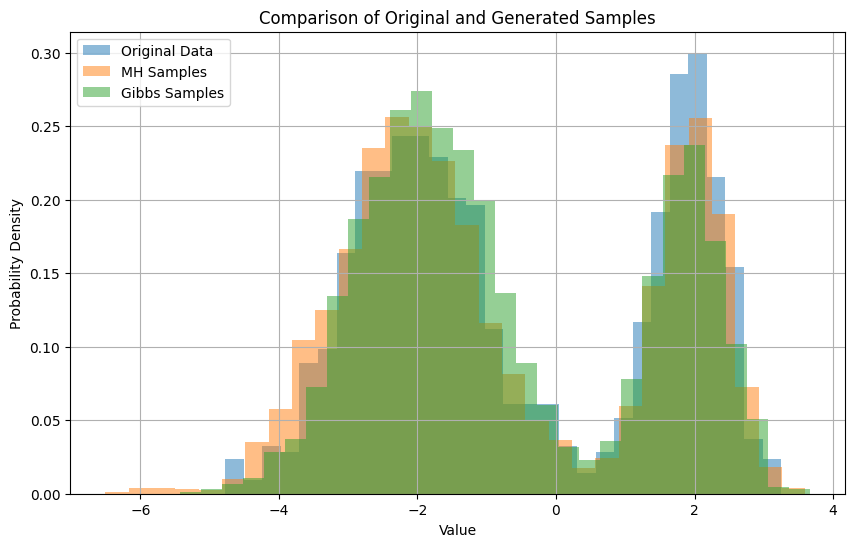

In [75]:
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Original Data')

plt.hist(mh_samples, bins=30, density=True, alpha=0.5, label='MH Samples')
plt.hist(gibbs_samples, bins=30, density=True, alpha=0.5, label='Gibbs Samples')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Comparison of Original and Generated Samples')
plt.legend()
plt.grid(True)
plt.show()